In [52]:
import pandas as pd
import geopandas as gpd
import requests

In [169]:
# 2020年10月の人口データを取得
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000020201',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'A1101',
     # 'cdAreaFrom': From,
     # 'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdTime':'2015100000',
     }

res = requests.get(URL,p)
text = res.json()
df_pop = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_pop['jcode'] = df_pop['@area'].astype(int)
df_pop['人口'] = df_pop['$'].astype(int)

print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])

項目名： Ａ　人口・世帯
ヒット件数： 1917


In [61]:
# 2020年10月の面積データを取得
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000020202',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':','.join(['B1101']),
     # 'cdAreaFrom': From,
     # 'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdTime':'2020100000',
     }

res = requests.get(URL,p)
text = res.json()
df_area = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_code = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ'][2]['CLASS'])
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])

項目名： Ｂ　自然環境
ヒット件数： 1917


In [62]:
# 人口密度が40人/km2以上で、市区町村コードが11000以上15000未満の市区町村を抽出
list_code = df_code['@parentCode'].astype(int).to_list()
df_pop = pd.merge(df_pop,df_code[['@code','@name']],left_on='@area',right_on='@code')
df_did = pd.merge(df_pop,df_area,on='@area',suffixes=('_pop','_area'))[['@area','@name','$_pop','$_area']]
df_did.columns = ['jcode','名前','人口','面積']
df_did['jcode'] = df_did['jcode'].astype(int)
df_did['人口'] = df_did['人口'].astype(int)
df_did['面積'] = df_did['面積'].astype(int)
df_did['人口密度'] = df_did['人口'] / df_did['面積']
df_did = df_did.query('jcode//1000 in [8,11,12,13,14]')
df_did = df_did.query('人口密度 > 40 & jcode not in @list_code')

list_did = df_did['jcode'].to_list()

In [63]:
df_did.head(30)

,jcode,名前,人口,面積,人口密度
527,11102,埼玉県 さいたま市 北区,149242,1686,88.518387
528,11103,埼玉県 さいたま市 大宮区,117784,1280,92.018750
529,11104,埼玉県 さいたま市 見沼区,165049,3069,53.779407
530,11105,埼玉県 さいたま市 中央区,103269,839,123.085816
531,11106,埼玉県 さいたま市 桜区,98661,1864,52.929721
532,11107,埼玉県 さいたま市 浦和区,164822,1151,143.198957
533,11108,埼玉県 さいたま市 南区,191563,1382,138.612880
534,11109,埼玉県 さいたま市 緑区,128321,2644,48.532905
538,11203,埼玉県 川口市,594274,6195,95.928006
541,11208,埼玉県 所沢市,342464,7211,47.491887


In [6]:
# 2000~2020までの廃置分合データの読み込み
df_2000 = pd.read_csv('data/setup_2000_2020/FEA_haitibungou-20241229011621.csv')
df_2000['DID'] = df_2000['標準地域コード'].astype(int).apply(lambda x: True if x in list_did else False)
df_2000 = df_2000.query('DID | 標準地域コード in [11244,14209]')
df_2000.to_csv('data/setup_2000_2020/haitibungou.csv',index=False)

In [7]:
df_2000

,標準地域コード,都道府県,政令市･郡･支庁･振興局等,政令市･郡･支庁･振興局等（ふりがな）,市区町村,市区町村（ふりがな）,廃置分合等施行年月日,改正事由,支庁・振興局等内郡（ふりがな）,事由パターン,支庁・振興局等内郡,告示年月日,告示番号,DID
2,11102,埼玉県,さいたま市,さいたまし,北区,きたく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
3,11103,埼玉県,さいたま市,さいたまし,大宮区,おおみやく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
4,11104,埼玉県,さいたま市,さいたまし,見沼区,みぬまく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
5,11105,埼玉県,さいたま市,さいたまし,中央区,ちゅうおうく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
6,11106,埼玉県,さいたま市,さいたまし,桜区,さくらく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
7,11107,埼玉県,さいたま市,さいたまし,浦和区,うらわく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
8,11108,埼玉県,さいたま市,さいたまし,南区,みなみく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
9,11109,埼玉県,さいたま市,さいたまし,緑区,みどりく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,NaN,区の新設,NaN,2002-11-21,66,True
19,11244,埼玉県,NaN,NaN,さいたま市,さいたまし,2001-05-01,浦和市(11204)、大宮市(11205)、与野市(11220)が合併し、さいたま市(112...,NaN,新設合併（コード追加あり）,NaN,2001-01-25,18,False
20,11245,埼玉県,NaN,NaN,ふじみ野市,ふじみのし,2005-10-01,上福岡市(11236)、大井町(11322)が合併し、ふじみ野市(11245)を新設,NaN,新設合併（コード追加あり）,NaN,2005-08-24,973,True


In [8]:
#　分析対象のコードを定義
list_jcode = list((set(list_did) - set(df_2000['標準地域コード'].astype(int).to_list())) | set([11204,11205,11220,11245,13229,14209]))
df_jcode = pd.DataFrame(list_jcode,columns=['jcode'])
df_jcode = df_jcode.sort_values('jcode')

# GCIの読み込み
df_gci = pd.read_csv('data/setup_2000_2020/code_gci.csv',header=None,names=['jcode','gci'])
df_jcode = pd.merge(df_jcode,df_gci,on='jcode',how='left')

def get_geom(gci):
    # print(gci)
    pref = gci[:2]
    try: 
        URL = f'https://geoshape.ex.nii.ac.jp/city/topojson/20001001/{pref}/{gci}.topojson'
        gdf = gpd.read_file(URL)
    except: 
        URL = f'https://geoshape.ex.nii.ac.jp/city/topojson/20200101/{pref}/{gci}.topojson'
        gdf = gpd.read_file(URL)
    return gdf.iloc[0,:]

# df_jcode = df_jcode.join(df_jcode['gci'].apply(lambda x: get_geom(x)))


In [65]:
pd.read_csv('./sources/MEA2015.csv', encoding='CP932')

,MEA,都市圏名,MEA Name,suburb,郊外,Suburb Name,通勤率,suburb2,郊外2,Suburb2 Name,通勤率2,suburb3,郊外3,Suburb3 Name,通勤率3,suburb4,郊外4,Suburb4 Name,通勤率4,DID人口
0,1100,札幌市・小樽市,Sapporo-Otaru,1217,江別市,Ebetsu-shi,0.389228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1899081
1,1100,札幌市・小樽市,Sapporo-Otaru,1234,北広島市,Kitahiroshima-shi,0.396273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1899081
2,1100,札幌市・小樽市,Sapporo-Otaru,1235,石狩市,Ishikari-shi,0.448710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1899081
3,1100,札幌市・小樽市,Sapporo-Otaru,1303,当別町,Tobetsu-cho,0.321140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1899081
4,1100,札幌市・小樽市,Sapporo-Otaru,1408,余市町,Yoichi-cho,0.109883,1406.0,古平町,Furubira-cho,0.113769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1899081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,47201,那覇市・浦添市,Naha,47362,八重瀬町,Yaese-cho,0.270521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318151
695,47211,沖縄市,Okinawa,47213,うるま市,Uruma-shi,0.173494,47314.0,金武町,Kin-cho,0.118670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122197
696,47211,沖縄市,Okinawa,47325,嘉手納町,Kadena-cho,0.131394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122197
697,47211,沖縄市,Okinawa,47326,北谷町,Chatan-cho,0.149773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122197


In [78]:
pd.read_csv('./sources/MEA2015C.csv', encoding='CP932')

,MEA,都市圏名,MEA Name,center,中心都市,Center Name,DID Population,Center Population,Employment Residence Ratio
0,1100,札幌市・小樽市,Sapporo-Otaru,1100,札幌市,Sapporo-shi,1899081,1952356,1.006833
1,1100,札幌市・小樽市,Sapporo-Otaru,1203,小樽市,Otaru-shi,104874,121924,1.036238
2,1202,函館市,Hakodate,1202,函館市,Hakodate-shi,229488,265979,1.050102
3,1204,旭川市,Asahikawa,1204,旭川市,Asahikawa-shi,313661,339605,1.007278
4,1205,室蘭市,Muroran,1205,室蘭市,Muroran-shi,69665,88564,1.197139
...,...,...,...,...,...,...,...,...,...
118,45203,延岡市,Nobeoka,45203,延岡市,Nobeoka-shi,82178,125159,1.022596
119,46201,鹿児島市,Kagoshima,46201,鹿児島市,Kagoshima-shi,482548,599814,1.019652
120,47201,那覇市・浦添市,Naha,47201,那覇市,Naha-shi,318151,319435,1.237920
121,47201,那覇市・浦添市,Naha,47208,浦添市,Urasoe-shi,111169,114232,1.082261


In [79]:
mea = pd.read_csv('./sources/MEA2015.csv', encoding='CP932')
meac = pd.read_csv('./sources/MEA2015C.csv', encoding='CP932')

In [ ]:
mea.rename(columns={'suburb':'jcode','郊外':'名前'})
meac.rename(columns={'center':'jcode','中心都市':'名前'})

In [81]:
meac.columns

Index(['MEA', '都市圏名', 'MEA Name', 'center', '中心都市', 'Center Name',
       'DID Population', 'Center Population', 'Employment Residence Ratio'],
      dtype='object')

# 都市雇用圏データの読み込み

In [170]:
df_pop

,@tab,@cat01,@area,@time,@unit,$,jcode,人口
0,00001,A1101,01100,2015100000,人,1952356,1100,1952356
1,00001,A1101,01101,2015100000,人,237627,1101,237627
2,00001,A1101,01102,2015100000,人,285321,1102,285321
3,00001,A1101,01103,2015100000,人,261912,1103,261912
4,00001,A1101,01104,2015100000,人,209584,1104,209584
...,...,...,...,...,...,...,...,...
1912,00001,A1101,47361,2015100000,人,7755,47361,7755
1913,00001,A1101,47362,2015100000,人,29066,47362,29066
1914,00001,A1101,47375,2015100000,人,1194,47375,1194
1915,00001,A1101,47381,2015100000,人,3998,47381,3998


In [ ]:
mea = pd.read_csv('./sources/MEA2015.csv', encoding='CP932').rename(columns={'suburb':'jcode','郊外':'名前'})
meac = pd.read_csv('./sources/MEA2015C.csv', encoding='CP932').rename(columns={'center':'jcode','中心都市':'名前'})
cols_mea = ['MEA', '都市圏名', 'jcode', '名前']
df_mea = pd.concat([mea[cols_mea],meac[cols_mea]])
df_mea = df_mea.merge(df_pop[['jcode','人口']], on='jcode', how='left')
df_mea = df_mea.query('(都市圏名 in ["東京"] & 人口 > 40000) | jcode in [,8220]').reset_index(drop=True)


df_gci = pd.read_csv('data/setup_2000_2020/code_gci.csv',header=None,names=['jcode','gci'])
df_mea = pd.merge(df_mea, df_gci, on='jcode', how='left')

df_mea = df_mea.join(df_mea['gci'].astype(str).apply(lambda x: get_geom(x)))

list_mea = df_mea['jcode'].to_list()

In [196]:
df_mea

,MEA,都市圏名,jcode,名前,人口,gci,id,N03_001,N03_002,N03_003,N03_004,N03_005,N03_006,N03_007,geometry,type
0,13100,東京,8208,龍ケ崎市,78342.0,08208A1968,gci:08208A1968,茨城県,None,None,龍ケ崎市,NaN,NaN,08208,MULTIPOLYGON (((140.1143673310327 35.947910717...,NaN
1,13100,東京,8217,取手市,106570.0,08217A1970,gci:08217A1970,茨城県,None,None,取手市,NaN,NaN,08217,MULTIPOLYGON (((140.12713554705465 35.87085727...,NaN
2,13100,東京,8224,守谷市,64753.0,08224A2002,gci:08224A2002,茨城県,None,None,守谷市,NaN,NaN,08224,MULTIPOLYGON (((139.99520288193483 35.90956659...,NaN
3,13100,東京,11201,川越市,350745.0,11201A1968,gci:11201A1968,埼玉県,None,None,川越市,NaN,NaN,11201,MULTIPOLYGON (((139.48709369207637 35.84203396...,NaN
4,13100,東京,11202,熊谷市,198742.0,11202A1968,gci:11202A1968,埼玉県,None,None,熊谷市,NaN,NaN,11202,MULTIPOLYGON (((139.38883062237275 36.10376411...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,13100,東京,14212,厚木市,225714.0,14212A1968,gci:14212A1968,神奈川県,None,None,厚木市,NaN,NaN,14212,MULTIPOLYGON (((139.2312182375411 35.440982076...,NaN
114,13100,東京,11100,さいたま市,1263979.0,11100A2003,gci:11100A2003,埼玉県,None,さいたま市,NaN,NaN,NaN,11100,MULTIPOLYGON (((139.5477586658992 35.934202455...,designated-city
115,13100,東京,12100,千葉市,971882.0,12100A1992,gci:12100A1992,千葉県,None,千葉市,NaN,NaN,NaN,12100,MULTIPOLYGON (((140.03494436030851 35.66963252...,designated-city
116,13100,東京,14100,横浜市,3724844.0,14100A1968,gci:14100A1968,神奈川県,None,横浜市,NaN,NaN,NaN,14100,MULTIPOLYGON (((139.62497232587225 35.39200002...,designated-city


<Axes: >

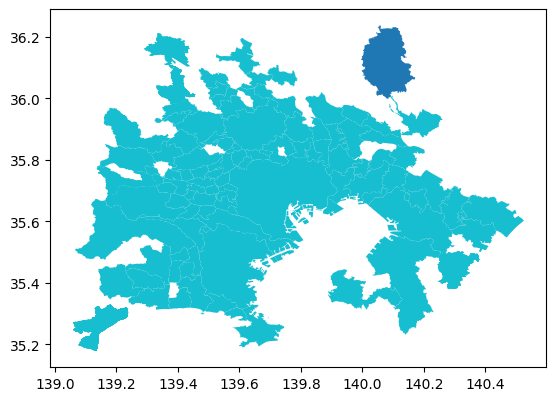

In [197]:
gdf_mea = gpd.GeoDataFrame(df_mea,geometry='geometry')
gdf_mea.plot('都市圏名')

In [157]:
df_2020_info = pd.read_csv('sources/FEA_hyoujun-20241231122757.csv')

def agg_jcode(code:int):
    if (code//100)%10 == 1:
        new_code = (code//100)*100
    else: new_code = code
    return new_code

df_2020_info['agg_jcode'] = df_2020_info['標準地域コード'].apply(agg_jcode)
df_2020_info = df_2020_info.query('agg_jcode in @list_mea & 標準地域コード%100 != 0')

In [158]:
list_mea_2020 = df_2020_info['標準地域コード'].to_list()

In [141]:
# 2000~2020までの廃置分合データの読み込み
df_2000 = pd.read_csv('./sources/FEA_haitibungou-20241231125108.csv')
df_2000['MEA'] = df_2000['標準地域コード'].astype(int).apply(lambda x: True if x in list_mea_2020 else False)
df_2000 = df_2000.query('MEA | 標準地域コード in [11244,14209,11213]')
# df_2000.to_csv('data/setup_2000_2020/haitibungou.csv',index=False)

In [142]:
df_2000

,標準地域コード,都道府県,政令市･郡･支庁･振興局等,政令市･郡･支庁･振興局等（ふりがな）,市区町村,市区町村（ふりがな）,廃置分合等施行年月日,改正事由,MEA
1,8205,茨城県,NaN,NaN,石岡市,いしおかし,2005-10-01,石岡市(08205)、八郷町(08463)が合併し、石岡市を新設,True
2,8211,茨城県,NaN,NaN,常総市,じょうそうし,2006-01-01,水海道市(08211)が常総市(08211)に名称変更,True
5,8224,茨城県,NaN,NaN,守谷市,もりやし,2002-02-02,守谷町(08561)が守谷市(08224)に市制施行,True
11,8230,茨城県,NaN,NaN,かすみがうら市,かすみがうらし,2005-03-28,霞ヶ浦町(08461)、千代田町(08464)が合併し、かすみがうら市(08230)を新設,True
16,8235,茨城県,NaN,NaN,つくばみらい市,つくばみらいし,2006-03-27,伊奈町(08482)、谷和原村(08483)が合併し、つくばみらい市(08235)を新設\r...,True
19,11100,埼玉県,さいたま市,さいたまし,NaN,NaN,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
20,11101,埼玉県,さいたま市,さいたまし,西区,にしく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
21,11102,埼玉県,さいたま市,さいたまし,北区,きたく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
22,11103,埼玉県,さいたま市,さいたまし,大宮区,おおみやく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
23,11104,埼玉県,さいたま市,さいたまし,見沼区,みぬまく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True


In [159]:
list_jcode = list((set(list_mea_2020) - set(df_2000['標準地域コード'].astype(int).to_list()))| set([8205,8211,8224,8230,8235,11204,11205,11110,11220,11202,11210,11214,11232,11238,11245,11246,12232,12237,12239,13229,14209]))

df_jcode = pd.DataFrame(list_jcode,columns=['jcode'])
df_jcode = df_jcode.sort_values('jcode')

# GCIの読み込み
df_gci = pd.read_csv('data/setup_2000_2020/code_gci.csv',header=None,names=['jcode','gci'])
df_jcode = pd.merge(df_jcode,df_gci,on='jcode',how='left')

def get_geom(gci):
    # print(gci)
    pref = gci[:2]
    try: 
        URL = f'https://geoshape.ex.nii.ac.jp/city/topojson/20001001/{pref}/{gci}.topojson'
        gdf = gpd.read_file(URL)
    except: 
        URL = f'https://geoshape.ex.nii.ac.jp/city/topojson/20200101/{pref}/{gci}.topojson'
        gdf = gpd.read_file(URL)
    return gdf.iloc[0,:]

df_jcode = df_jcode.join(df_jcode['gci'].apply(lambda x: get_geom(x)))

<Axes: >

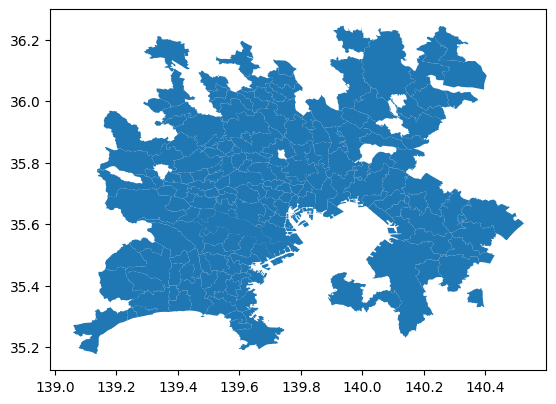

In [160]:
# 結合先Jcodeデータを作成
df_jcode = df_jcode.drop(columns=['gci','id','N03_002','N03_005','N03_006','N03_007'])
df_jcode = gpd.GeoDataFrame(df_jcode,geometry='geometry')
df_jcode.to_file('data/setup_2000_2020/jcode.geojson',driver='GeoJSON')
df_jcode.plot()

In [161]:
df_2020_info

,標準地域コード,都道府県,政令市･郡･支庁･振興局等,政令市･郡･支庁･振興局等（ふりがな）,市区町村,市区町村（ふりがな）,廃置分合等施行年月日,廃置分合等情報有無,都市種別,過疎地域市町村,標準地域コード告示年月日,標準地域コード告示番号,標準地域コード廃止年月日,agg_jcode
2,8203,茨城県,NaN,NaN,土浦市,つちうらし,2009-03-10,有,NaN,NaN,NaN,NaN,2023-01-01,8203
4,8205,茨城県,NaN,NaN,石岡市,いしおかし,2009-03-10,有,NaN,NaN,NaN,NaN,NaN,8205
6,8208,茨城県,NaN,NaN,龍ケ崎市,りゅうがさきし,2019-07-01,有,NaN,NaN,NaN,NaN,NaN,8208
7,8210,茨城県,NaN,NaN,下妻市,しもつまし,2020-07-01,有,NaN,NaN,NaN,NaN,NaN,8210
8,8211,茨城県,NaN,NaN,常総市,じょうそうし,2006-01-01,有,NaN,NaN,2005-09-05,1031.0,NaN,8211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,14321,神奈川県,高座郡,こうざぐん,寒川町,さむかわまち,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14321
289,14341,神奈川県,中郡,なかぐん,大磯町,おおいそまち,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14341
290,14342,神奈川県,中郡,なかぐん,二宮町,にのみやまち,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14342
299,14401,神奈川県,愛甲郡,あいこうぐん,愛川町,あいかわまち,1971-09-01,有,NaN,NaN,NaN,NaN,NaN,14401


In [132]:
df_2020_info.query('(標準地域コード//100)%10 == 1').head(30)

,標準地域コード,都道府県,政令市･郡･支庁･振興局等,政令市･郡･支庁･振興局等（ふりがな）,市区町村,市区町村（ふりがな）,廃置分合等施行年月日,廃置分合等情報有無,都市種別,過疎地域市町村,標準地域コード告示年月日,標準地域コード告示番号,標準地域コード廃止年月日,jcode
44,11100,埼玉県,さいたま市,さいたまし,NaN,NaN,2005-04-01,有,政令指定都市,NaN,2005-03-23,341.0,NaN,11100
45,11101,埼玉県,さいたま市,さいたまし,西区,にしく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
46,11102,埼玉県,さいたま市,さいたまし,北区,きたく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
47,11103,埼玉県,さいたま市,さいたまし,大宮区,おおみやく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
48,11104,埼玉県,さいたま市,さいたまし,見沼区,みぬまく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
49,11105,埼玉県,さいたま市,さいたまし,中央区,ちゅうおうく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
50,11106,埼玉県,さいたま市,さいたまし,桜区,さくらく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
51,11107,埼玉県,さいたま市,さいたまし,浦和区,うらわく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
52,11108,埼玉県,さいたま市,さいたまし,南区,みなみく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100
53,11109,埼玉県,さいたま市,さいたまし,緑区,みどりく,2003-04-01,有,NaN,NaN,2003-01-14,15.0,NaN,11100


In [10]:
#　各年のjcodeの対応表を作成
df_2000 = pd.concat([
    pd.DataFrame({
        'jcode_2000':list(set(list_jcode) - set([11204,11205,11220,11245,11245,13229,13229,14209])),
        'jcode_2020':list(set(list_jcode) - set([11204,11205,11220,11245,11245,13229,13229,14209])),
    }),
    pd.DataFrame({
        'jcode_2000':[11204,11205,11220,11236,11322,13216,13217,14209],
        'jcode_2020':[11204,11205,11220,11245,11245,13229,13229,14209],
    })    
],axis=0).sort_values('jcode_2000')
df_2000_info = pd.read_csv('data/setup_2000_2020/FEA_hyoujun-20241229002857.csv')[['標準地域コード', '都道府県', '政令市･郡･支庁･振興局等','市区町村']]
df_2000 = df_2000.merge(df_2000_info, left_on='jcode_2000', right_on='標準地域コード', how='left').drop('標準地域コード',axis=1)

df_2020 = pd.concat([
    pd.DataFrame({
        'jcode_2020':list(set(list_jcode) - set([11205,11205,11205,11205,11220,11204,11204,11204,11204,11245,13229,14209,14209,14209])),
        'jcode_2000':list(set(list_jcode) - set([11205,11205,11205,11205,11220,11204,11204,11204,11204,11245,13229,14209,14209,14209])),
    }),
    pd.DataFrame({
        'jcode_2020':[11101,11102,11103,11104,11105,11106,11107,11108,11109,11245,13229,14151,14152,14153],
        'jcode_2000':[11205,11205,11205,11205,11220,11204,11204,11204,11204,11245,13229,14209,14209,14209],
    })    
],axis=0).sort_values('jcode_2020')
df_2020_info = pd.read_csv('data/setup_2000_2020/FEA_hyoujun-20241229003008.csv')[['標準地域コード', '都道府県', '政令市･郡･支庁･振興局等','市区町村']]
df_2020 = df_2020.merge(df_2020_info, left_on='jcode_2020', right_on='標準地域コード', how='left').drop('標準地域コード',axis=1)

In [11]:
df_2000.to_csv('data/2000/jcode_2000.csv',index=False)
df_2020.to_csv('data/2020/jcode_2020.csv',index=False)

# 土地賦存量
https://www.e-stat.go.jp/stat-search?page=1&layout=normal&toukei=00200502&survey=%E5%B8%82%E5%8C%BA%E7%94%BA%E6%9D%91&metadata=1&data=1
から取得

In [37]:
df_land = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000031956084&fileKind=0', skiprows=[0,1,2,3,4,6,7,8,9], index_col='市区町村')

In [38]:
df_land['jcode'] = df_land['市区\n町村\nｺｰﾄﾞ']
df_land['K_i'] = df_land['可住地面積']
df_land = df_2020.merge(df_land[['jcode','K_i']], left_on='jcode_2020', right_on='jcode').drop(columns='jcode')
df_land = df_land.groupby('jcode_2000').agg({'K_i':'sum'})

In [39]:
df_land

,K_i
jcode_2000,
11203,61.34
11204,68.46
11205,87.90
11208,65.51
11219,43.44
...,...
14207,32.72
14209,140.06
14213,25.88


In [40]:
df_land.to_csv('sources/K_i.csv',index=False)